<a href="https://colab.research.google.com/github/AayushGrover101/pneumonia_classification/blob/master/pneumonia_classification_replicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [2]:
import time
import copy
import glob
import random

import numpy as np
import pandas as pd

# displaying images and manipulating them
from PIL import Image

# progress-bar
from tqdm.auto import tqdm 

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# pytorch
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34

In [3]:
# read files from google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [4]:
# import train and test data

train_normal = glob.glob("/gdrive/My Drive/Colab Notebooks/data/train/NORMAL/*")
train_pneumonia = glob.glob("/gdrive/My Drive/Colab Notebooks/data/train/PNEUMONIA/*")

test_normal = glob.glob("/gdrive/My Drive/Colab Notebooks/data/test/NORMAL/*")
test_pneumonia = glob.glob("/gdrive/My Drive/Colab Notebooks/data/test/PNEUMONIA/*")

In [5]:
# combine train and test data into a single path
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

In [6]:
# set labels (1 for pneumonia, 0 for normal)
train_labels = [0] * len(train_normal) + [1] * len(train_pneumonia)
test_labels = [0] * len(test_normal) + [1] * len(test_pneumonia)

In [7]:
print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

5216 5216
624 624


In [8]:
# split train and test data for validation sets
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, 
                                                                        stratify=train_labels)

In [10]:
# display random and pneumonic x-ray images
def show_random_images():

    # random image paths
    path_random_normal = random.choice(train_normal)
    path_random_normal2 = random.choice(train_normal)
    path_random_normal3 = random.choice(train_normal)
    path_random_normal4 = random.choice(train_normal)
    path_random_normal5 = random.choice(train_normal)
    path_random_abnormal = random.choice(train_pneumonia)
    path_random_abnormal2 = random.choice(train_pneumonia)
    path_random_abnormal3 = random.choice(train_pneumonia)
    path_random_abnormal4 = random.choice(train_pneumonia)

    # figure creation + axes
    fig = plt.figure(figsize=(10, 10))
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-ray")

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
    ax2.set_title("Abnormal X-ray")

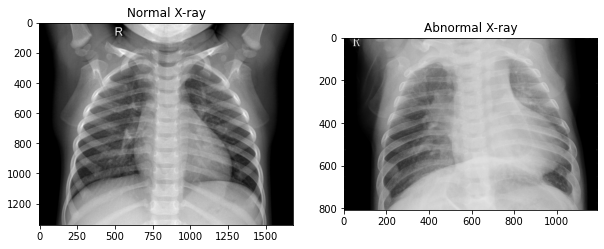

In [11]:
show_random_images()

In [ ]:
# creating a dataset class to allow for use in PyTorch
class XrayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)
g
    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        label = self.labels[index]
        label = torch.tensor([label])

        return image, label

In [ ]:
# PyTorch model

class PneumoniaNet(nn.Module):
    def __init__(self, pretrained=True):
        super(PneumoniaNet, self).__init__()
        self.backbone = resnet18(pretrained=pretrained)
        self.fc = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)

        x = x.view(x.size(0), 512)
        x = self.fc(x)

        return x

In [ ]:
# image transform and dataset initialization

image_size = (500, 500)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, test_transform)

In [ ]:
# dataloaders and perameters for training

pretrained = True

model = PneumoniaNet(pretrained=pretrained)

lr = 3e-3

num_epochs = 5
train_batch_size = 16
valid_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=5, shuffle=False)

dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader 
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"]) // 10,
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

batch_sizes = {
    "train": train_batch_size,
    "val": valid_batch_size
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
model.cuda()

In [ ]:
! nvidia-smi

In [ ]:
# training the model (loop)

def train_model(model, criterion, optimizer, num_epochs, device="cuda"):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in tqdm(range(num_epochs), leave=False):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]), 
                                            leave=False, 
                                            total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    
                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if (i % logging_steps[phase] == 0) & (i > 0):
                    avg_loss = running_loss / ((i+1) * batch_sizes[phase])
                    avg_acc = running_corrects / ((i+1) * batch_sizes[phase])   
                    
                    print(f"[{phase}]: {epoch+1} / {num_epochs} | loss : {avg_loss} | acc : {avg_acc}")
                    
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    
    print(f"training took {time_elapsed} seconds")
    
    model.load_state_dict(best_model_wts)
    
    return model

In [ ]:
model = train_model(model, criterion, optimizer, num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/245 [00:00<?, ?it/s]

[train]: 1 / 5 | loss : 0.2444787809997797 | acc : 0.9024999737739563
[train]: 1 / 5 | loss : 0.19964845337885984 | acc : 0.9221938848495483
[train]: 1 / 5 | loss : 0.1824906016763759 | acc : 0.9280821681022644
[train]: 1 / 5 | loss : 0.18788062848304352 | acc : 0.924613356590271
[train]: 1 / 5 | loss : 0.18112631525444098 | acc : 0.9256197810173035
[train]: 1 / 5 | loss : 0.18145202304525623 | acc : 0.9271551966667175
[train]: 1 / 5 | loss : 0.1736604572775272 | acc : 0.9301035404205322
[train]: 1 / 5 | loss : 0.17109299990121718 | acc : 0.9306994676589966
[train]: 1 / 5 | loss : 0.16458596886148513 | acc : 0.9328917264938354
[train]: 1 / 5 | loss : 0.16499183265515507 | acc : 0.9317946434020996
train Loss: 0.1654 Acc: 0.9317


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 1 / 5 | loss : 0.8127295209301842 | acc : 0.6041666865348816
[val]: 1 / 5 | loss : 0.8034229190910563 | acc : 0.6213235259056091
[val]: 1 / 5 | loss : 0.7582213282585144 | acc : 0.6274999976158142
[val]: 1 / 5 | loss : 0.7592315140998724 | acc : 0.6344696879386902
[val]: 1 / 5 | loss : 0.7420546317972788 | acc : 0.6493902206420898
[val]: 1 / 5 | loss : 0.7310807902594002 | acc : 0.6568877696990967
[val]: 1 / 5 | loss : 0.7379111916872493 | acc : 0.6513158082962036
[val]: 1 / 5 | loss : 0.7237278770941954 | acc : 0.6576923131942749
[val]: 1 / 5 | loss : 0.7154900850090262 | acc : 0.6609588861465454
[val]: 1 / 5 | loss : 0.7172756171152915 | acc : 0.6604938507080078
val Loss: 0.7191 Acc: 0.6595



  0%|          | 0/245 [00:00<?, ?it/s]

[train]: 2 / 5 | loss : 0.24901512920856475 | acc : 0.9124999642372131
[train]: 2 / 5 | loss : 0.23062970466455635 | acc : 0.9119897484779358
[train]: 2 / 5 | loss : 0.2199911592043426 | acc : 0.9186643958091736
[train]: 2 / 5 | loss : 0.1958141270064816 | acc : 0.9271907210350037
[train]: 2 / 5 | loss : 0.1948135118346569 | acc : 0.9266528487205505
[train]: 2 / 5 | loss : 0.19908487096685787 | acc : 0.9254310131072998
[train]: 2 / 5 | loss : 0.20057487114161782 | acc : 0.9245561957359314
[train]: 2 / 5 | loss : 0.19673708180650837 | acc : 0.9238989353179932
[train]: 2 / 5 | loss : 0.19501188017153245 | acc : 0.9256912469863892
[train]: 2 / 5 | loss : 0.19795532584870504 | acc : 0.9245332479476929
train Loss: 0.1987 Acc: 0.9236


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 2 / 5 | loss : 0.8869310981697507 | acc : 0.8055555820465088
[val]: 2 / 5 | loss : 0.8449355425203547 | acc : 0.7977941036224365
[val]: 2 / 5 | loss : 0.803501455783844 | acc : 0.7999999523162842
[val]: 2 / 5 | loss : 0.8095276685375156 | acc : 0.8011363744735718
[val]: 2 / 5 | loss : 0.853943284328391 | acc : 0.7804877758026123
[val]: 2 / 5 | loss : 0.8747953489726904 | acc : 0.7704081535339355
[val]: 2 / 5 | loss : 0.8693673696957136 | acc : 0.7719298601150513
[val]: 2 / 5 | loss : 0.9259883552789688 | acc : 0.7701923251152039
[val]: 2 / 5 | loss : 0.9228925894792765 | acc : 0.7688356041908264
[val]: 2 / 5 | loss : 0.9217254285827096 | acc : 0.7716049551963806
val Loss: 0.9267 Acc: 0.7715



  0%|          | 0/245 [00:00<?, ?it/s]

[train]: 3 / 5 | loss : 0.1879338523000479 | acc : 0.9300000071525574
[train]: 3 / 5 | loss : 0.1836916295317363 | acc : 0.9311224222183228
[train]: 3 / 5 | loss : 0.172945333542685 | acc : 0.9340753555297852
[train]: 3 / 5 | loss : 0.16002979854448246 | acc : 0.938144326210022
[train]: 3 / 5 | loss : 0.15672140717044597 | acc : 0.9395660758018494
[train]: 3 / 5 | loss : 0.15047010982987183 | acc : 0.9418103694915771
[train]: 3 / 5 | loss : 0.151032686194945 | acc : 0.9430473446846008
[train]: 3 / 5 | loss : 0.1449655370854343 | acc : 0.9459196925163269
[train]: 3 / 5 | loss : 0.15308555098859944 | acc : 0.9438363909721375
[train]: 3 / 5 | loss : 0.1568960701791701 | acc : 0.9408714175224304
train Loss: 0.1560 Acc: 0.9412


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 3 / 5 | loss : 0.2792833886212773 | acc : 0.881944477558136
[val]: 3 / 5 | loss : 0.2731243319371167 | acc : 0.875
[val]: 3 / 5 | loss : 0.26586754322052003 | acc : 0.8774999976158142
[val]: 3 / 5 | loss : 0.2713716955799045 | acc : 0.8787878751754761
[val]: 3 / 5 | loss : 0.27127259479063315 | acc : 0.8734755516052246
[val]: 3 / 5 | loss : 0.2603467888369852 | acc : 0.8788264989852905
[val]: 3 / 5 | loss : 0.25879350945092083 | acc : 0.8793859481811523
[val]: 3 / 5 | loss : 0.26211591489039937 | acc : 0.8769230842590332
[val]: 3 / 5 | loss : 0.25679628596934556 | acc : 0.8792808055877686
[val]: 3 / 5 | loss : 0.25784912434073143 | acc : 0.8765432238578796
val Loss: 0.2591 Acc: 0.8765



  0%|          | 0/245 [00:00<?, ?it/s]

[train]: 4 / 5 | loss : 0.1383867956697941 | acc : 0.9375
[train]: 4 / 5 | loss : 0.15122963486201302 | acc : 0.9336734414100647
[train]: 4 / 5 | loss : 0.13791554486251448 | acc : 0.9417808055877686
[train]: 4 / 5 | loss : 0.15346115459832027 | acc : 0.938144326210022
[train]: 4 / 5 | loss : 0.15410988663192376 | acc : 0.9385330080986023
[train]: 4 / 5 | loss : 0.15304352205632063 | acc : 0.9379310607910156
[train]: 4 / 5 | loss : 0.1450621517672694 | acc : 0.9426774978637695
[train]: 4 / 5 | loss : 0.14376254629710486 | acc : 0.9426813125610352
[train]: 4 / 5 | loss : 0.14070317645724606 | acc : 0.9447004795074463
[train]: 4 / 5 | loss : 0.1394813693248323 | acc : 0.9442427754402161
train Loss: 0.1404 Acc: 0.9440


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 4 / 5 | loss : 0.18804099245203865 | acc : 0.9027777910232544
[val]: 4 / 5 | loss : 0.18235534221372185 | acc : 0.9154411554336548
[val]: 4 / 5 | loss : 0.16174069814383985 | acc : 0.92249995470047
[val]: 4 / 5 | loss : 0.16442291534534006 | acc : 0.9204545617103577
[val]: 4 / 5 | loss : 0.17719183957613097 | acc : 0.9161584973335266
[val]: 4 / 5 | loss : 0.18636837263344502 | acc : 0.9132652878761292
[val]: 4 / 5 | loss : 0.18287943051964567 | acc : 0.9177631735801697
[val]: 4 / 5 | loss : 0.19252823009513892 | acc : 0.9182692170143127
[val]: 4 / 5 | loss : 0.19032810835091218 | acc : 0.9195205569267273
[val]: 4 / 5 | loss : 0.19449119290543926 | acc : 0.9182099103927612
val Loss: 0.1964 Acc: 0.9172



  0%|          | 0/245 [00:00<?, ?it/s]

[train]: 5 / 5 | loss : 0.18981598757207394 | acc : 0.9350000023841858
[train]: 5 / 5 | loss : 0.1588102694676847 | acc : 0.9451530575752258
[train]: 5 / 5 | loss : 0.1503274963581807 | acc : 0.9520547986030579
[train]: 5 / 5 | loss : 0.13957241927897654 | acc : 0.9529638886451721
[train]: 5 / 5 | loss : 0.14297454000242854 | acc : 0.9524793028831482
[train]: 5 / 5 | loss : 0.13377869975399867 | acc : 0.9560344815254211
[train]: 5 / 5 | loss : 0.12506745192745822 | acc : 0.9582100510597229
[train]: 5 / 5 | loss : 0.12517372398381482 | acc : 0.9559585452079773
[train]: 5 / 5 | loss : 0.1243427375670574 | acc : 0.9565092325210571
[train]: 5 / 5 | loss : 0.12752987940977348 | acc : 0.9546162486076355
train Loss: 0.1276 Acc: 0.9548


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 5 / 5 | loss : 0.4906614108218087 | acc : 0.8125
[val]: 5 / 5 | loss : 0.43881766848704395 | acc : 0.8088235259056091
[val]: 5 / 5 | loss : 0.4124810273945332 | acc : 0.8075000047683716
[val]: 5 / 5 | loss : 0.4362711157988418 | acc : 0.8049242496490479
[val]: 5 / 5 | loss : 0.49742107066075975 | acc : 0.7835365533828735
[val]: 5 / 5 | loss : 0.5181634256578221 | acc : 0.7780612111091614
[val]: 5 / 5 | loss : 0.5006086909326545 | acc : 0.7828947305679321
[val]: 5 / 5 | loss : 0.5104005604409254 | acc : 0.7769230604171753
[val]: 5 / 5 | loss : 0.5100725515145962 | acc : 0.7739725708961487
[val]: 5 / 5 | loss : 0.5108069696084216 | acc : 0.7770061492919922
val Loss: 0.5143 Acc: 0.7768

training took 3293.146117210388 seconds


In [ ]:
# initializing test paths
test_paths = glob.glob("/gdrive/My Drive/Colab Notebooks/data/test/NORMAL/*") + glob.glob("/gdrive/My Drive/Colab Notebooks/data/test/PNEUMONIA/*")
test_labels = [0] * len(glob.glob("/gdrive/My Drive/Colab Notebooks/data/test/NORMAL/*")) + [1] * len(glob.glob("/gdrive/My Drive/Colab Notebooks/data/test/PNEUMONIA/*"))

In [ ]:
# initialize test dataset
test_dataset = XrayDataset(test_paths, test_labels, test_transform)

In [ ]:
# initialize test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
# create predictions and compare to real labels
y_pred = []
y_true = []

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
    with torch.no_grad():
        predictions = model(tensors.cuda())
        predictions = predictions.sigmoid()
        predictions = predictions > 0.5
        y_pred.append(predictions)

        y_true.append(labels)

y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

In [ ]:
y_pred = y_pred.cpu().numpy()
y_true = y_true.numpy()

In [ ]:
y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

In [ ]:
y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_true, y_pred )

0.0